The International Union for the Conservation of Nature (IUCN) currently lists over 40,000 species as endangered, with around 9,000 as critically endangered and at severe risk of extinction. Known risk factors for extinction primarily include climate change, invasive species, and habitat loss, among other factors. Gomulkiewicz and Holt (1995) consider cases in which natural selection can prevent extinction in three mathematical models: a 2-step model, a discrete-time quantitative genetic model, and a continuous-time single locus model. However, their models all assume a sharp decline in fitness to represent an abrupt change in the environment, which is largely irreflective of the real world. As such, our project seeks to expand on the models proposed by Gomulkiewicz and Holt by asking questions including (but not limited to): what if environmental change was gradual, as in climate change?

In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# define the gradual two-step model: here, relative fitness declines gradually and then may recover via evolution
#define the simple two-step model: here, relative fitness gradually declines
def two_step_model_gradual(n_init, w_start, w_end, generations=100):
    """
    Simulate a two-step model with gradual environmental decline and constant relative fitness (no evolution).
    
    Parameters:
    n_init (int): Initial population size.
    w_start (float): Initial relative fitness.
    w_end (float): Final relative fitness after environmental decline.
    generations (int): Number of generations to simulate.
    
    Returns:
    np.ndarray: Array of population sizes at each generation.
    """
    
    # Initialize the population size
    n = n_init
    population_sizes = np.zeros(generations)
    
    # Create a linearly decreasing sequence of w values
    w_values = np.linspace(w_start, w_end, generations)
    
    for t in range(generations):
        population_sizes[t] = n
        n = n * w_values[t]  # Update population size based on time-dependent relative fitness
    
    return population_sizes

In [28]:
#same as above, but selection increases fitness each generation while environment gradually worsens
def two_step_with_evolving_gradual(n_init, w_start, w_end, s, generations=100):
    """
    Simulate a two-step model with evolving relative fitness and gradual environmental decline.
    
    Parameters:
    n_init (int): Initial population size.
    w_start (float): Initial relative fitness.
    w_end (float): Final relative fitness after environmental decline.
    s (float): Selection coefficient.
    generations (int): Number of generations to simulate.
    
    Returns:
    np.ndarray: Array of population sizes at each generation.
    """
    
    # Initialize the population size
    n = n_init
    population_sizes = np.zeros(generations)
    
    # Create a linearly decreasing sequence of baseline w values
    w_base = np.linspace(w_start, w_end, generations)
    
    for t in range(generations):
        population_sizes[t] = n
        w_effective = w_base[t] + s * t  # Apply both environmental decline and evolutionary improvement
        n = int(n * w_effective)  # Update population size
        
        #if we reach above the initial population size, stop
        if n > n_init:
            break
    
    # Fill the remaining generations with the last population size
    population_sizes[t+1:] = n

    return population_sizes

In [29]:
#run gradual decline simulations (no evolution vs with evolution)
pops_noevolution = two_step_model_gradual(100, w_start=1.0, w_end=0.5, generations=100)
pops_evolution = two_step_with_evolving_gradual(100, w_start=1.0, w_end=0.5, s=0.01, generations=100)

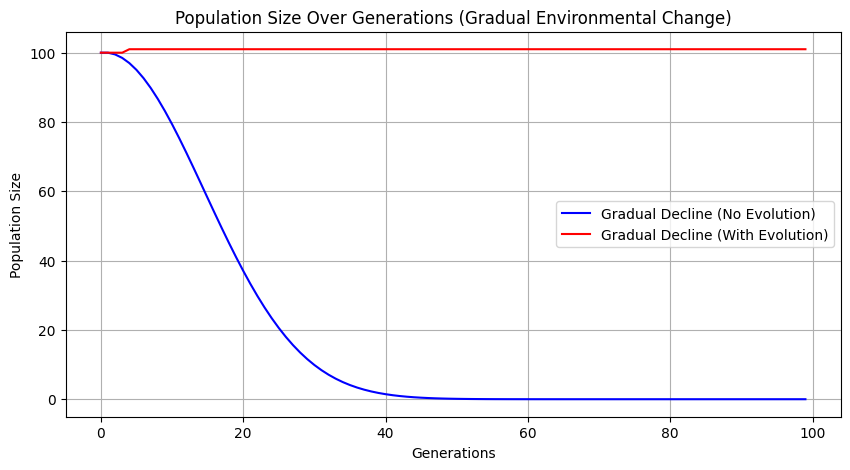

In [30]:
#plot this first run
plt.figure(figsize=(10, 5))
plt.plot(pops_noevolution, label='Gradual Decline (No Evolution)', color='blue')
plt.plot(pops_evolution, label='Gradual Decline (With Evolution)', color='red')
plt.title('Population Size Over Generations (Gradual Environmental Change)')
plt.xlabel('Generations')
plt.ylabel('Population Size')
plt.legend()
plt.grid()
plt.show()

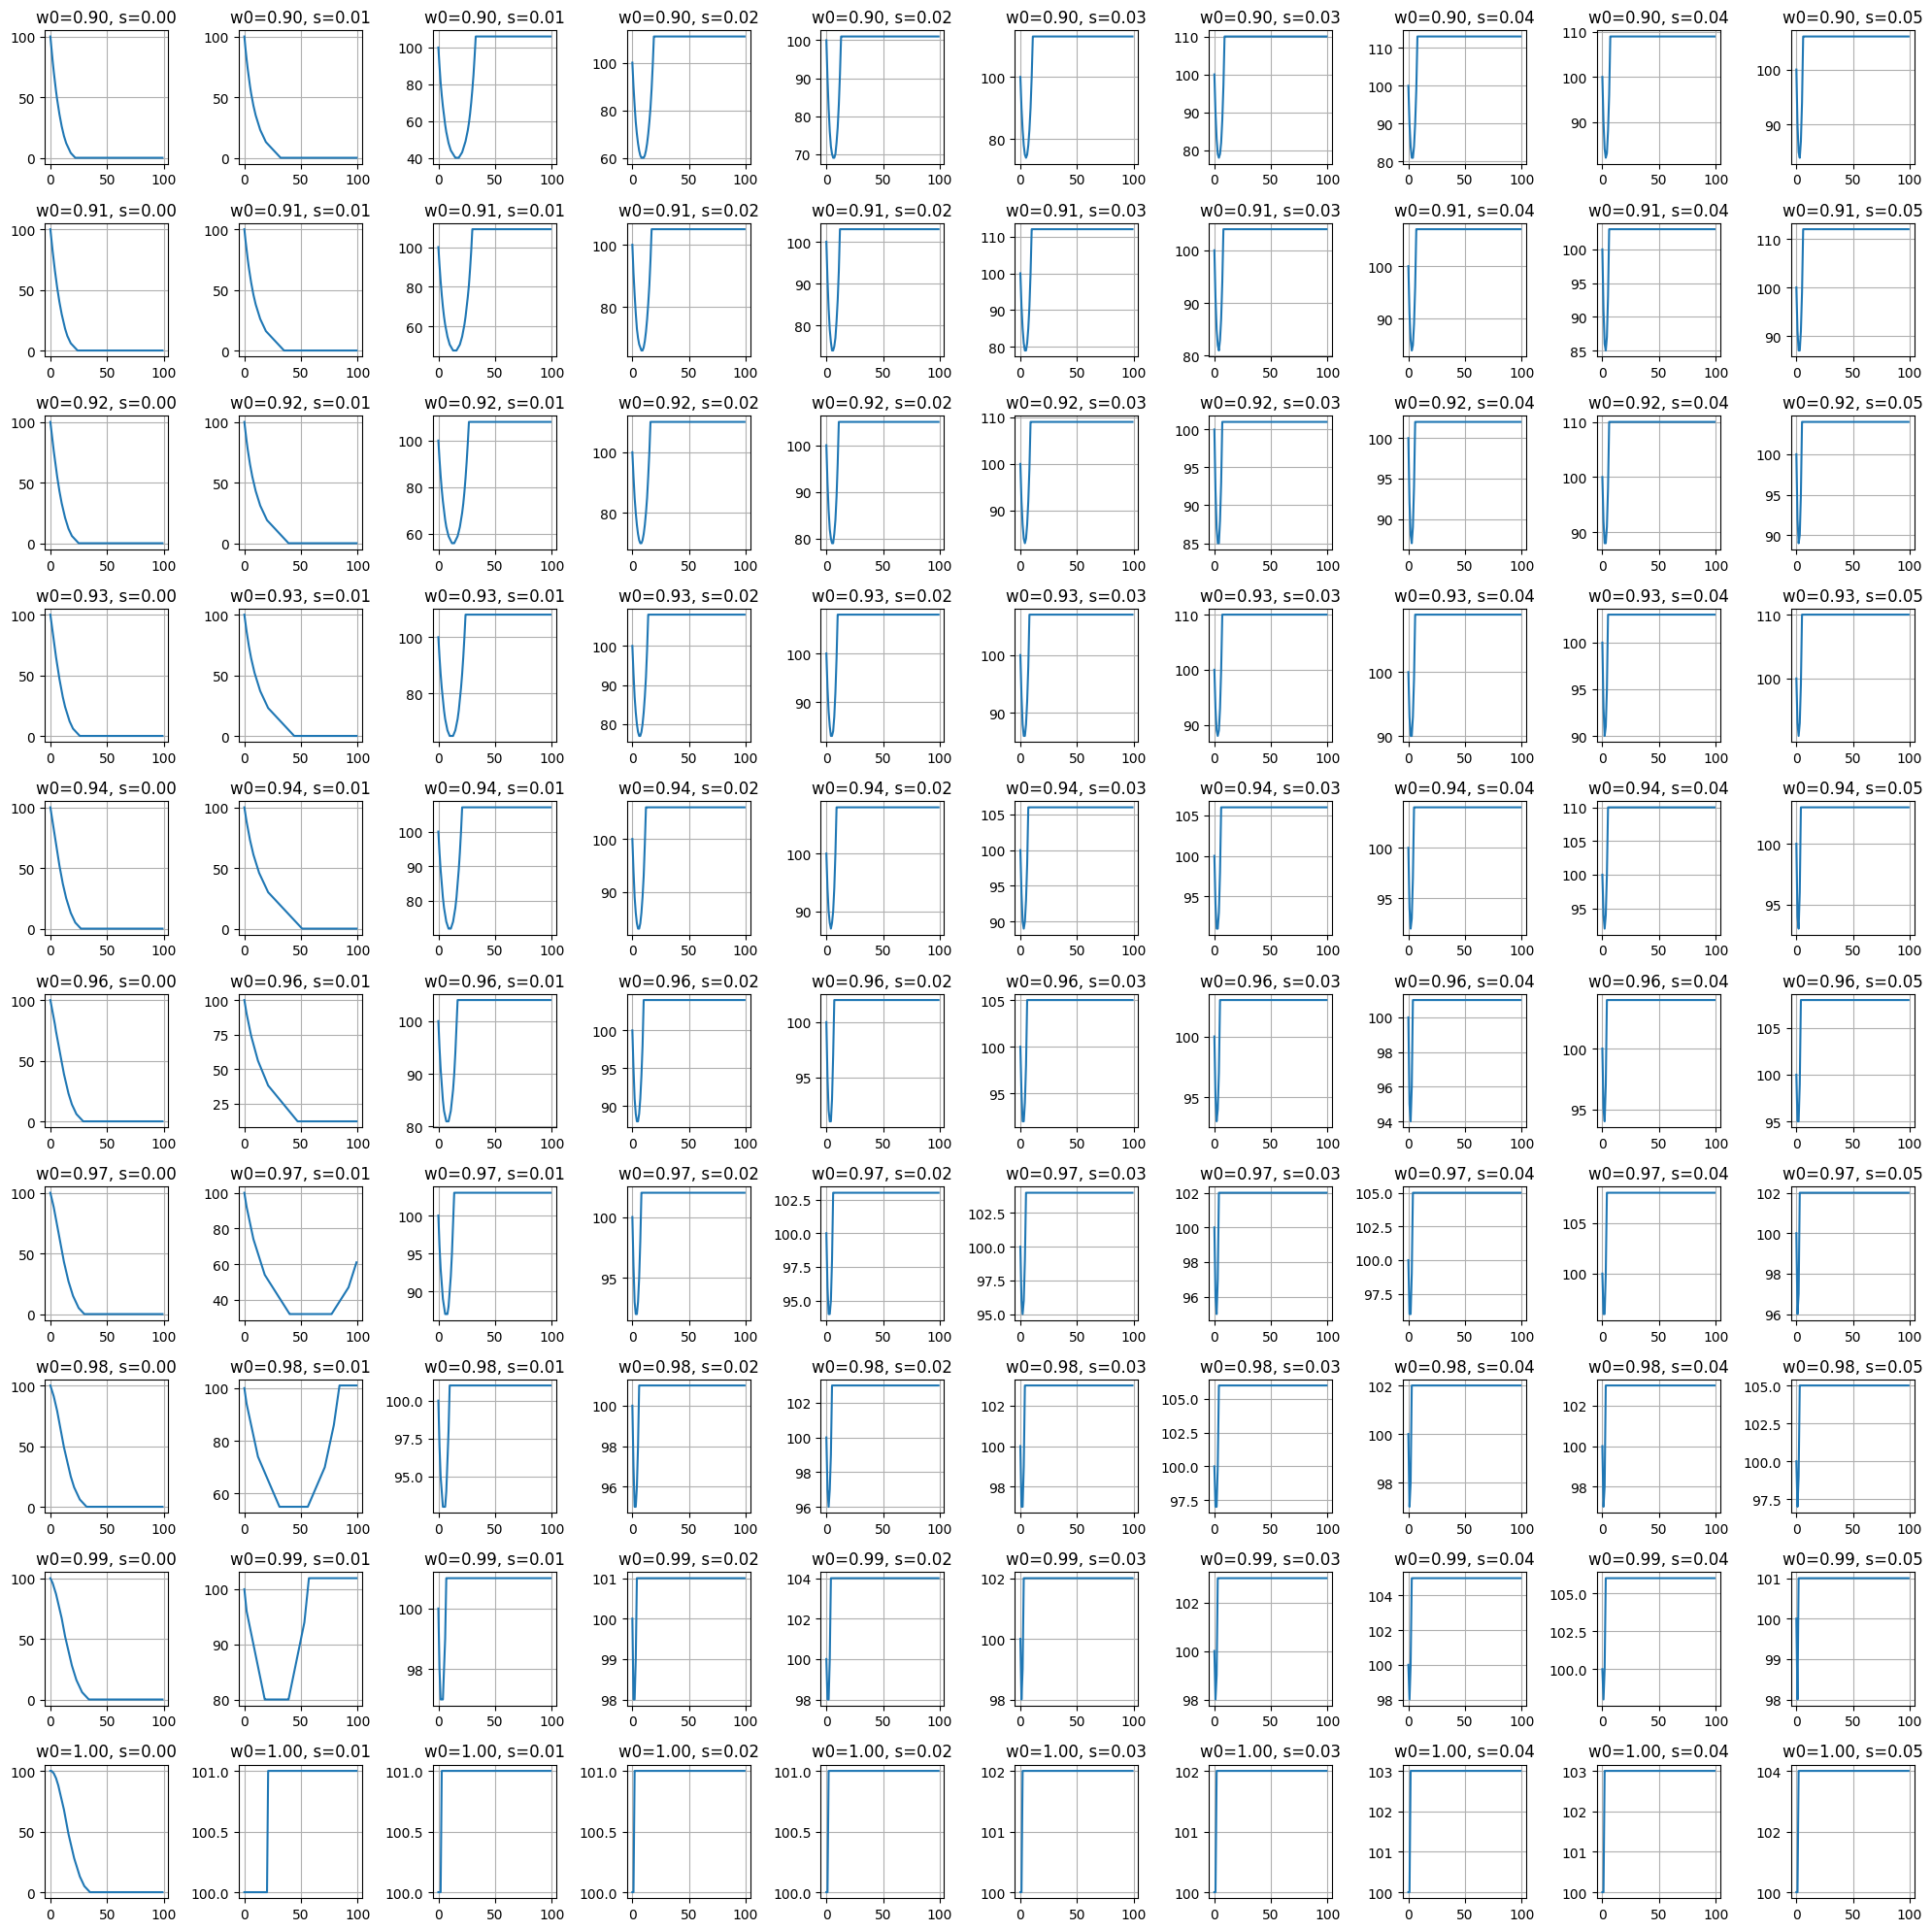

In [31]:
#try a variety of parameters
w_vals = np.linspace(0.9, 1.0, 10)  # w_start values
s_vals = np.linspace(0, 0.05, 10)   # selection coefficients
pops_all = []

for w in w_vals:
    for s in s_vals:
        pops = two_step_with_evolving_gradual(100, w_start=w, w_end=0.5, s=s, generations=100)
        pops_all.append(pops)

#plot all the runs in a grid of 10x10 subplots
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i, pops in enumerate(pops_all):
    ax = axs[i // 10, i % 10]
    ax.plot(pops)
    ax.set_title(f'w0={w_vals[i // 10]:.2f}, s={s_vals[i % 10]:.2f}')
    ax.grid()
plt.tight_layout()
plt.show()

In [32]:
#functions for model 2: discrete-time, quantitative genetic (with gradual environmental change)

#helper function: calculate absolute fitness
def absolute_fitness(w_max, z, w):
    return w_max * np.exp(-(z ** 2) / (2 * w))

#helper function: sample phenotypes from a normal distribution
#this has mean d_t and variance P
def sample_phenotypes(d_t, P, n):
    return np.random.normal(d_t, np.sqrt(P), n)

#helper function: calculate the absolute mean fitness
#this is the absolute fitness (above function) times the probability density of each phenotype
def absolute_mean_fitness(phenotypes, w_max, w, P):
    if len(phenotypes) == 0:
        return 0
    fitnesses = absolute_fitness(w_max, phenotypes, w)

    #get probability density of each phenotype
    probs = (1 / np.sqrt(2 * np.pi * P)) * np.exp(-(phenotypes ** 2) / (2 * P))

    #multiply fitness by probability density
    weighted_fitness = fitnesses * probs
    return np.sum(weighted_fitness) / len(phenotypes)

#helper function: change d_t
def change_dt(d_t, P, h2, w):
    return d_t + (-1 * h2 * d_t * P)/(P + w)

In [33]:
#now we can run the model
def quantgen_model_gradual(n_init, w_max, w, P, h2, generations=100, n_sims=1, shift_per_gen=0.01, printout=False):
    """
    Simulate a quantitative genetic model with gradual environmental change.
    
    Parameters:
    n_init (int): Population size.
    generations (int): Number of generations to simulate.
    w_max (float): Maximum absolute fitness.
    w (float): Width of corresponding Gaussian function.
    P (float): Phenotypic variance.
    h2 (float): Heritability.
    shift_per_gen (float): Change in optimum per generation (gradual shift).
    n_sims (int): Number of simulations to run.
    
    Returns:
    np.ndarray: Array of population sizes at each generation.
    """
    
    sim_results = np.zeros((n_sims, generations))
    mean_pops = np.zeros(generations)

    for sim in range(n_sims):
        d_t = 1
        n = n_init
        for t in range(generations):
            #sample phenotypes
            phenos = sample_phenotypes(d_t, P, n)

            #get the current absolute mean fitness
            mean_fitness = absolute_mean_fitness(phenos, w_max, w, P)
            n = int(n * mean_fitness)
            sim_results[sim, t] = n
            mean_pops[t] += n

            #update d_t
            d_t = change_dt(d_t, P, h2, w)

            #gradual shift in environmental optimum
            d_t += shift_per_gen

        if printout:
            print(f"Simulation {sim + 1} completed")

    mean_pops /= n_sims
    return sim_results, mean_pops

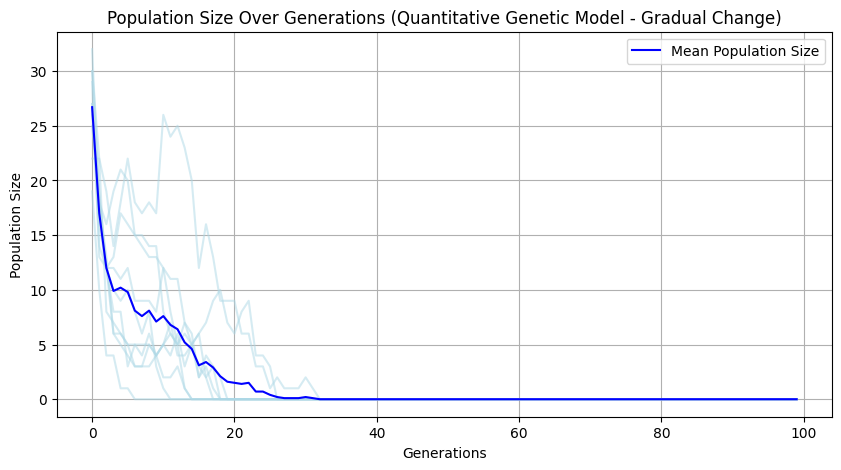

In [34]:
#run the model
n_init = 100
w_max = 3
w = 0.1
P = 0.3 
h2 = 0.6
pops, mean_pops = quantgen_model_gradual(n_init, w_max, w, P, h2, generations=100, n_sims=10, shift_per_gen=0.01)

#plot the results
plt.figure(figsize=(10, 5))
plt.plot(pops.T, color='lightblue', alpha=0.5)
plt.plot(mean_pops, color='blue', label='Mean Population Size')
plt.title('Population Size Over Generations (Quantitative Genetic Model - Gradual Change)')
plt.xlabel('Generations')
plt.ylabel('Population Size')
plt.legend()
plt.grid()
plt.show()

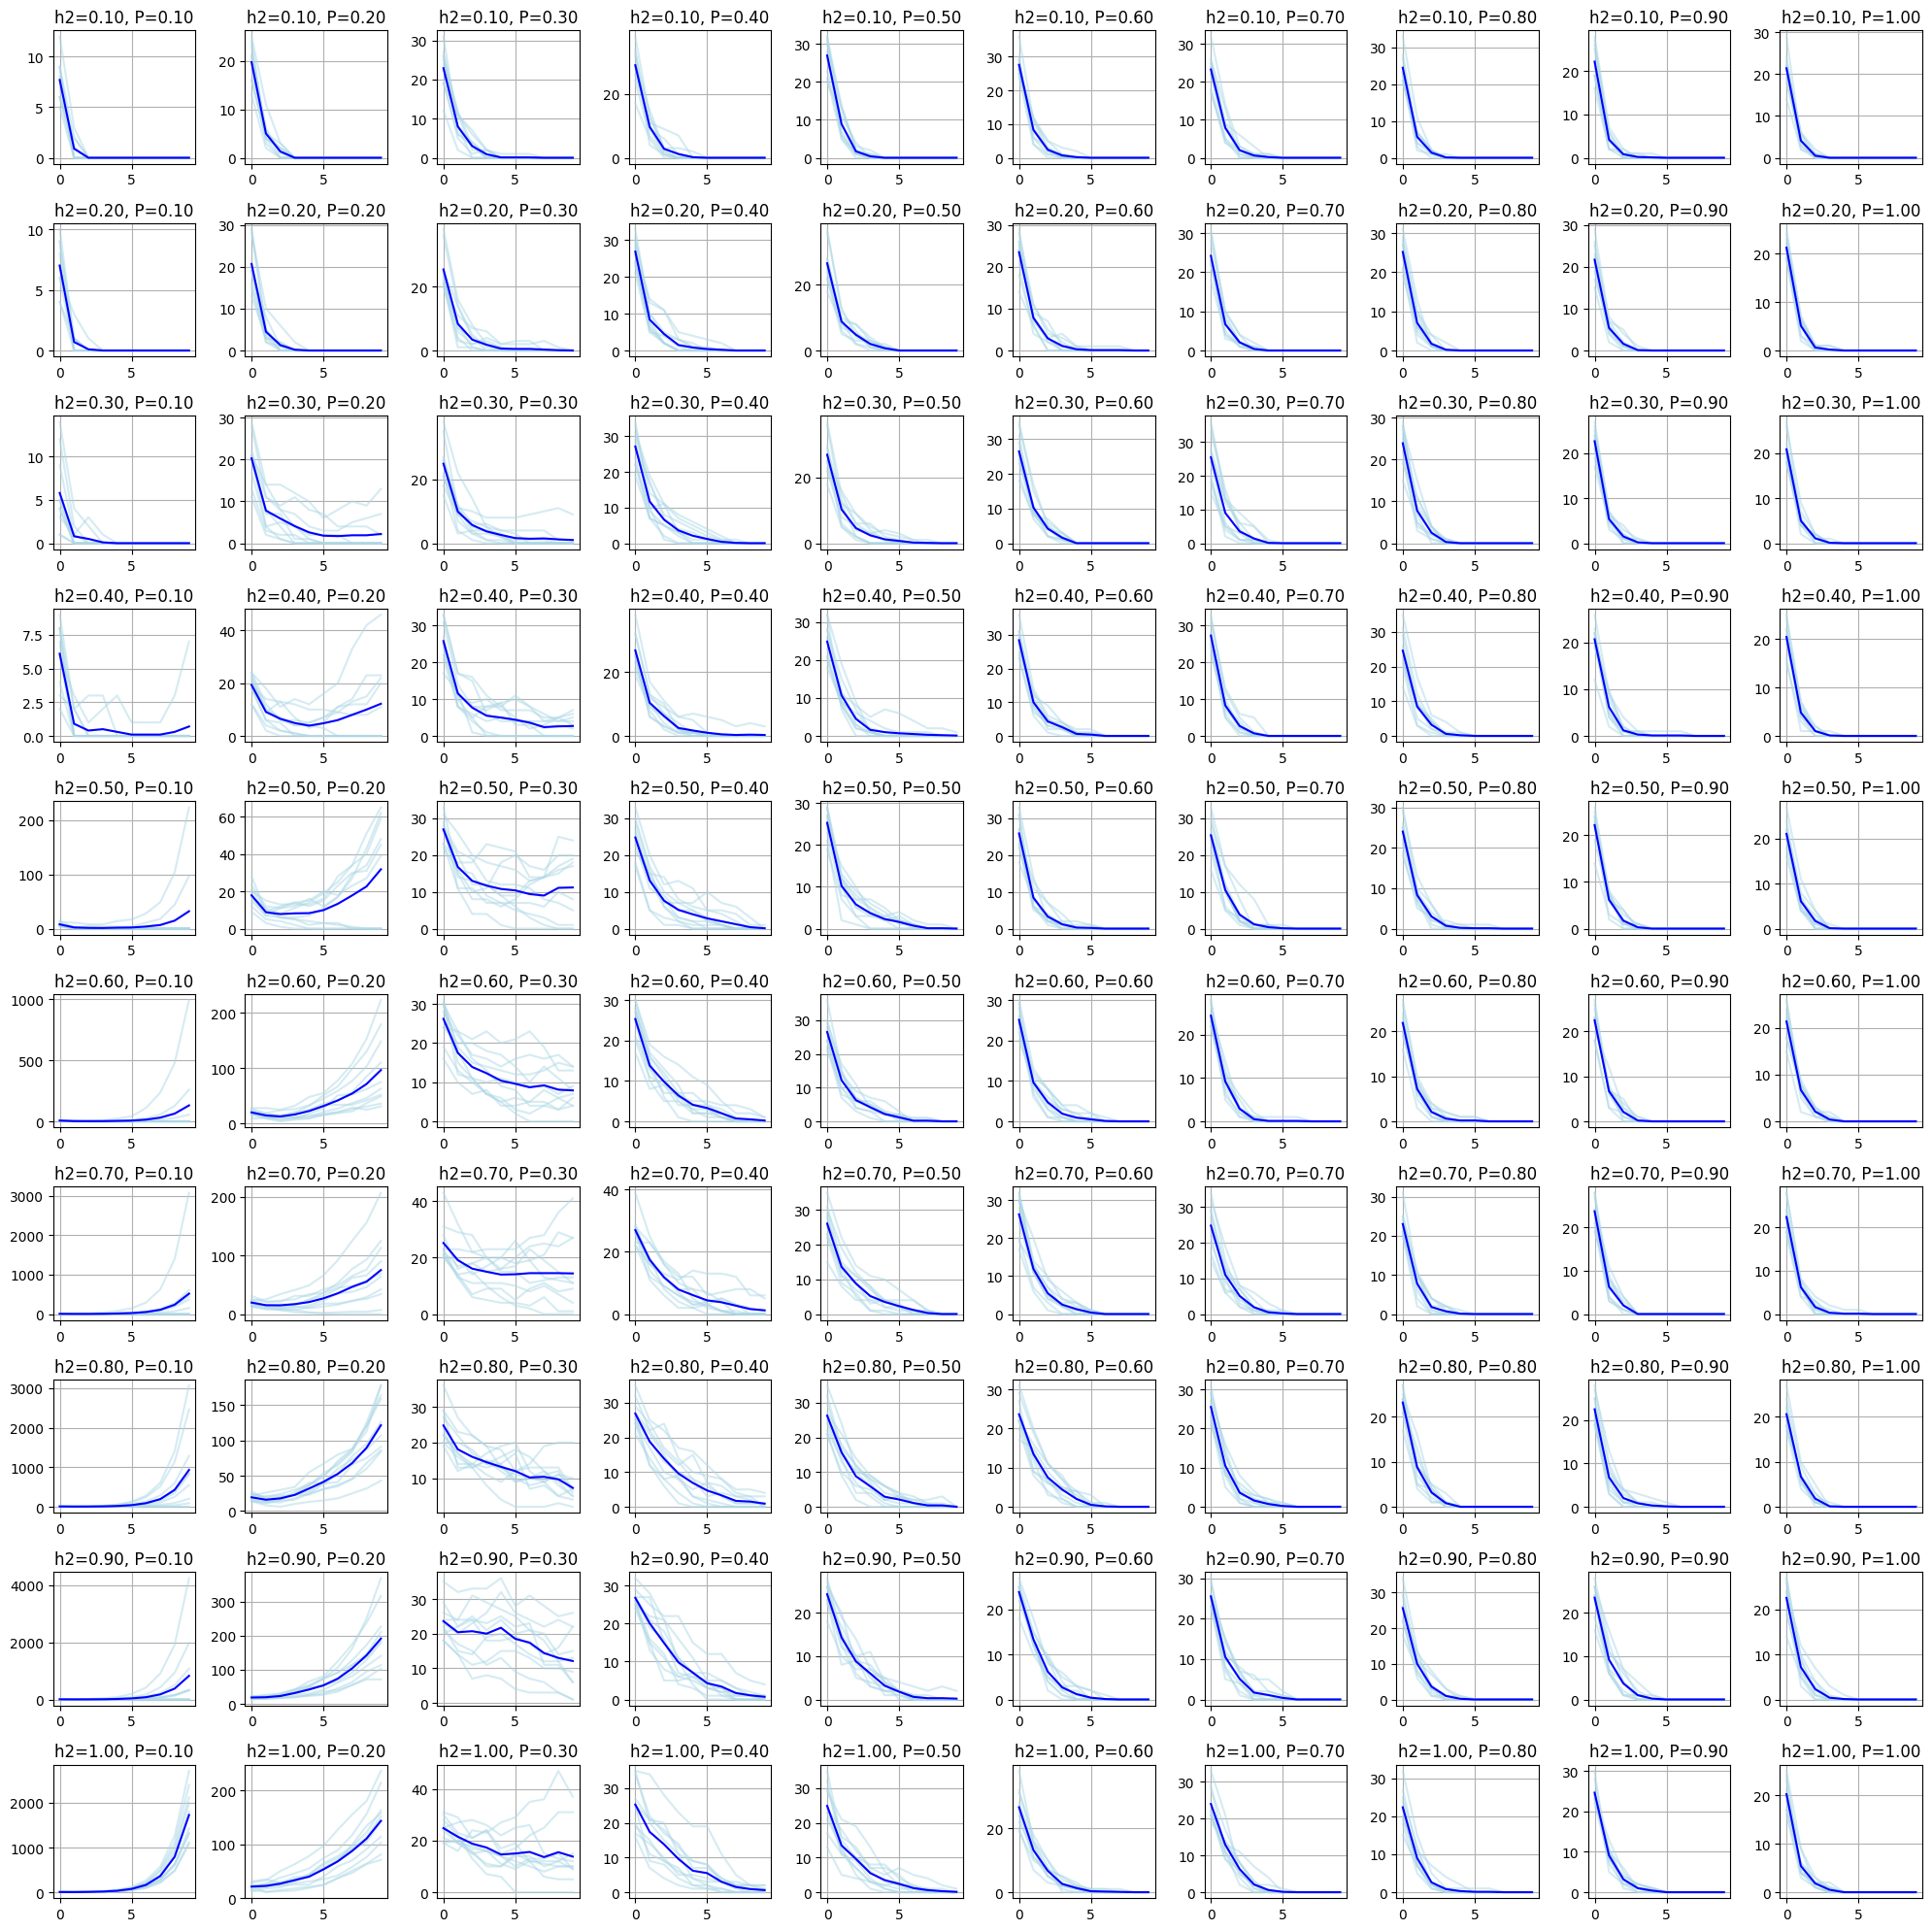

In [35]:
#same as simple two-step model, but with various values of P and h2
h2s = np.linspace(0.1, 1, 10)
Ps = np.linspace(0.1, 1, 10)
pops_all = []
mean_pops_all = []
for h2 in h2s:
    for P in Ps:
        pops, mean_pops = quantgen_model_gradual(n_init, w_max, w, P, h2, generations=10, n_sims=10, shift_per_gen=0.01)
        pops_all.append(pops)
        mean_pops_all.append(mean_pops)

#plot all the runs in a grid of 10x10 subplots
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i, pops in enumerate(pops_all):
    ax = axs[i // 10, i % 10]
    ax.plot(pops.T, color='lightblue', alpha=0.5)
    ax.plot(mean_pops_all[i], color='blue', label='Mean Population Size')
    ax.set_title(f'h2={h2s[i // 10]:.2f}, P={Ps[i % 10]:.2f}')
    ax.grid()
plt.tight_layout()
plt.show()

In [36]:
#this one diploid locus model will take m_max, s, n_0, q_0 (initial maladaptation), generations as parameters
def diploid_locus_model_gradual(m_max_start, m_max_end, s, n_0, q_0, generations=100):
    """
    Simulate a diploid locus model with gradual environmental decline (m_max decreases over time).
    
    Parameters:
    m_max_start (float): Initial maximum fitness.
    m_max_end (float): Final maximum fitness after environmental decline.
    s (float): Difference in fitness for the maladaptive allele.
    n_0 (int): Initial population size.
    q_0 (float): Initial maladaptation / frequency of the maladaptive allele.
    generations (int): Number of generations to simulate.
    
    Returns:
    np.ndarray: Array of population sizes at each generation.
    """

    # Ensure selection coefficient is large enough at start
    if s < m_max_start:
        raise ValueError("Selection coefficient s must be greater than or equal to starting m_max.")
    
    # Linearly decline m_max over generations
    m_max_values = np.linspace(m_max_start, m_max_end, generations)
    
    # Initialize the population size
    n = n_0
    q = q_0
    p = 1 - q  # Frequency of the beneficial allele

    # Initialize the population size array
    population_sizes = np.zeros(generations)

    for t in range(generations):
        m_max = m_max_values[t]
        m11 = m_max
        m12 = m_max - (s / 2)
        m22 = m_max - s

        population_sizes[t] = n
        m_t = m11 * (p ** 2) + m12 * (2 * p * q) + m22 * (q ** 2)
        n_next = n * m_t + n

        # Calculate the next generation frequencies
        p2_next = (n * (p ** 2)) * m11
        pq_next = (n * (2 * p * q)) * m12
        q2_next = (n * (q ** 2)) * m22

        total = p2_next + pq_next + q2_next
        p_next = (p2_next + 0.5 * pq_next) / total
        q_next = 1 - p_next

        # Update the population size and allele frequencies
        n = n_next
        p = p_next
        q = q_next

        # If population crashes
        if n_next <= 0:
            population_sizes[t:] = 0
            break

    return population_sizes

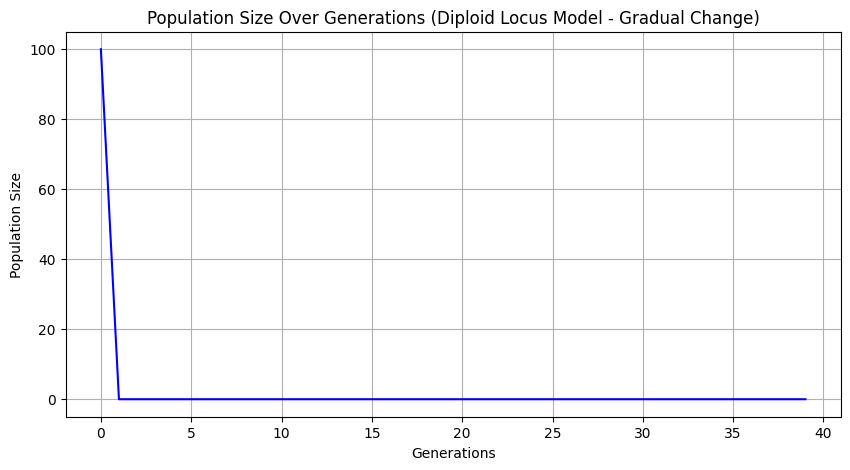

In [37]:
#run the model
m_max_start = 0.2
m_max_end = 0.05
s = 0.25
n_0 = 100
q_0 = 0.8
pops = diploid_locus_model_gradual(m_max_start, m_max_end, s, n_0, q_0, generations=40)

#plot the results
plt.figure(figsize=(10, 5))
plt.plot(pops, color='blue')
plt.title('Population Size Over Generations (Diploid Locus Model - Gradual Change)')
plt.xlabel('Generations')
plt.ylabel('Population Size')
plt.grid()
plt.show()

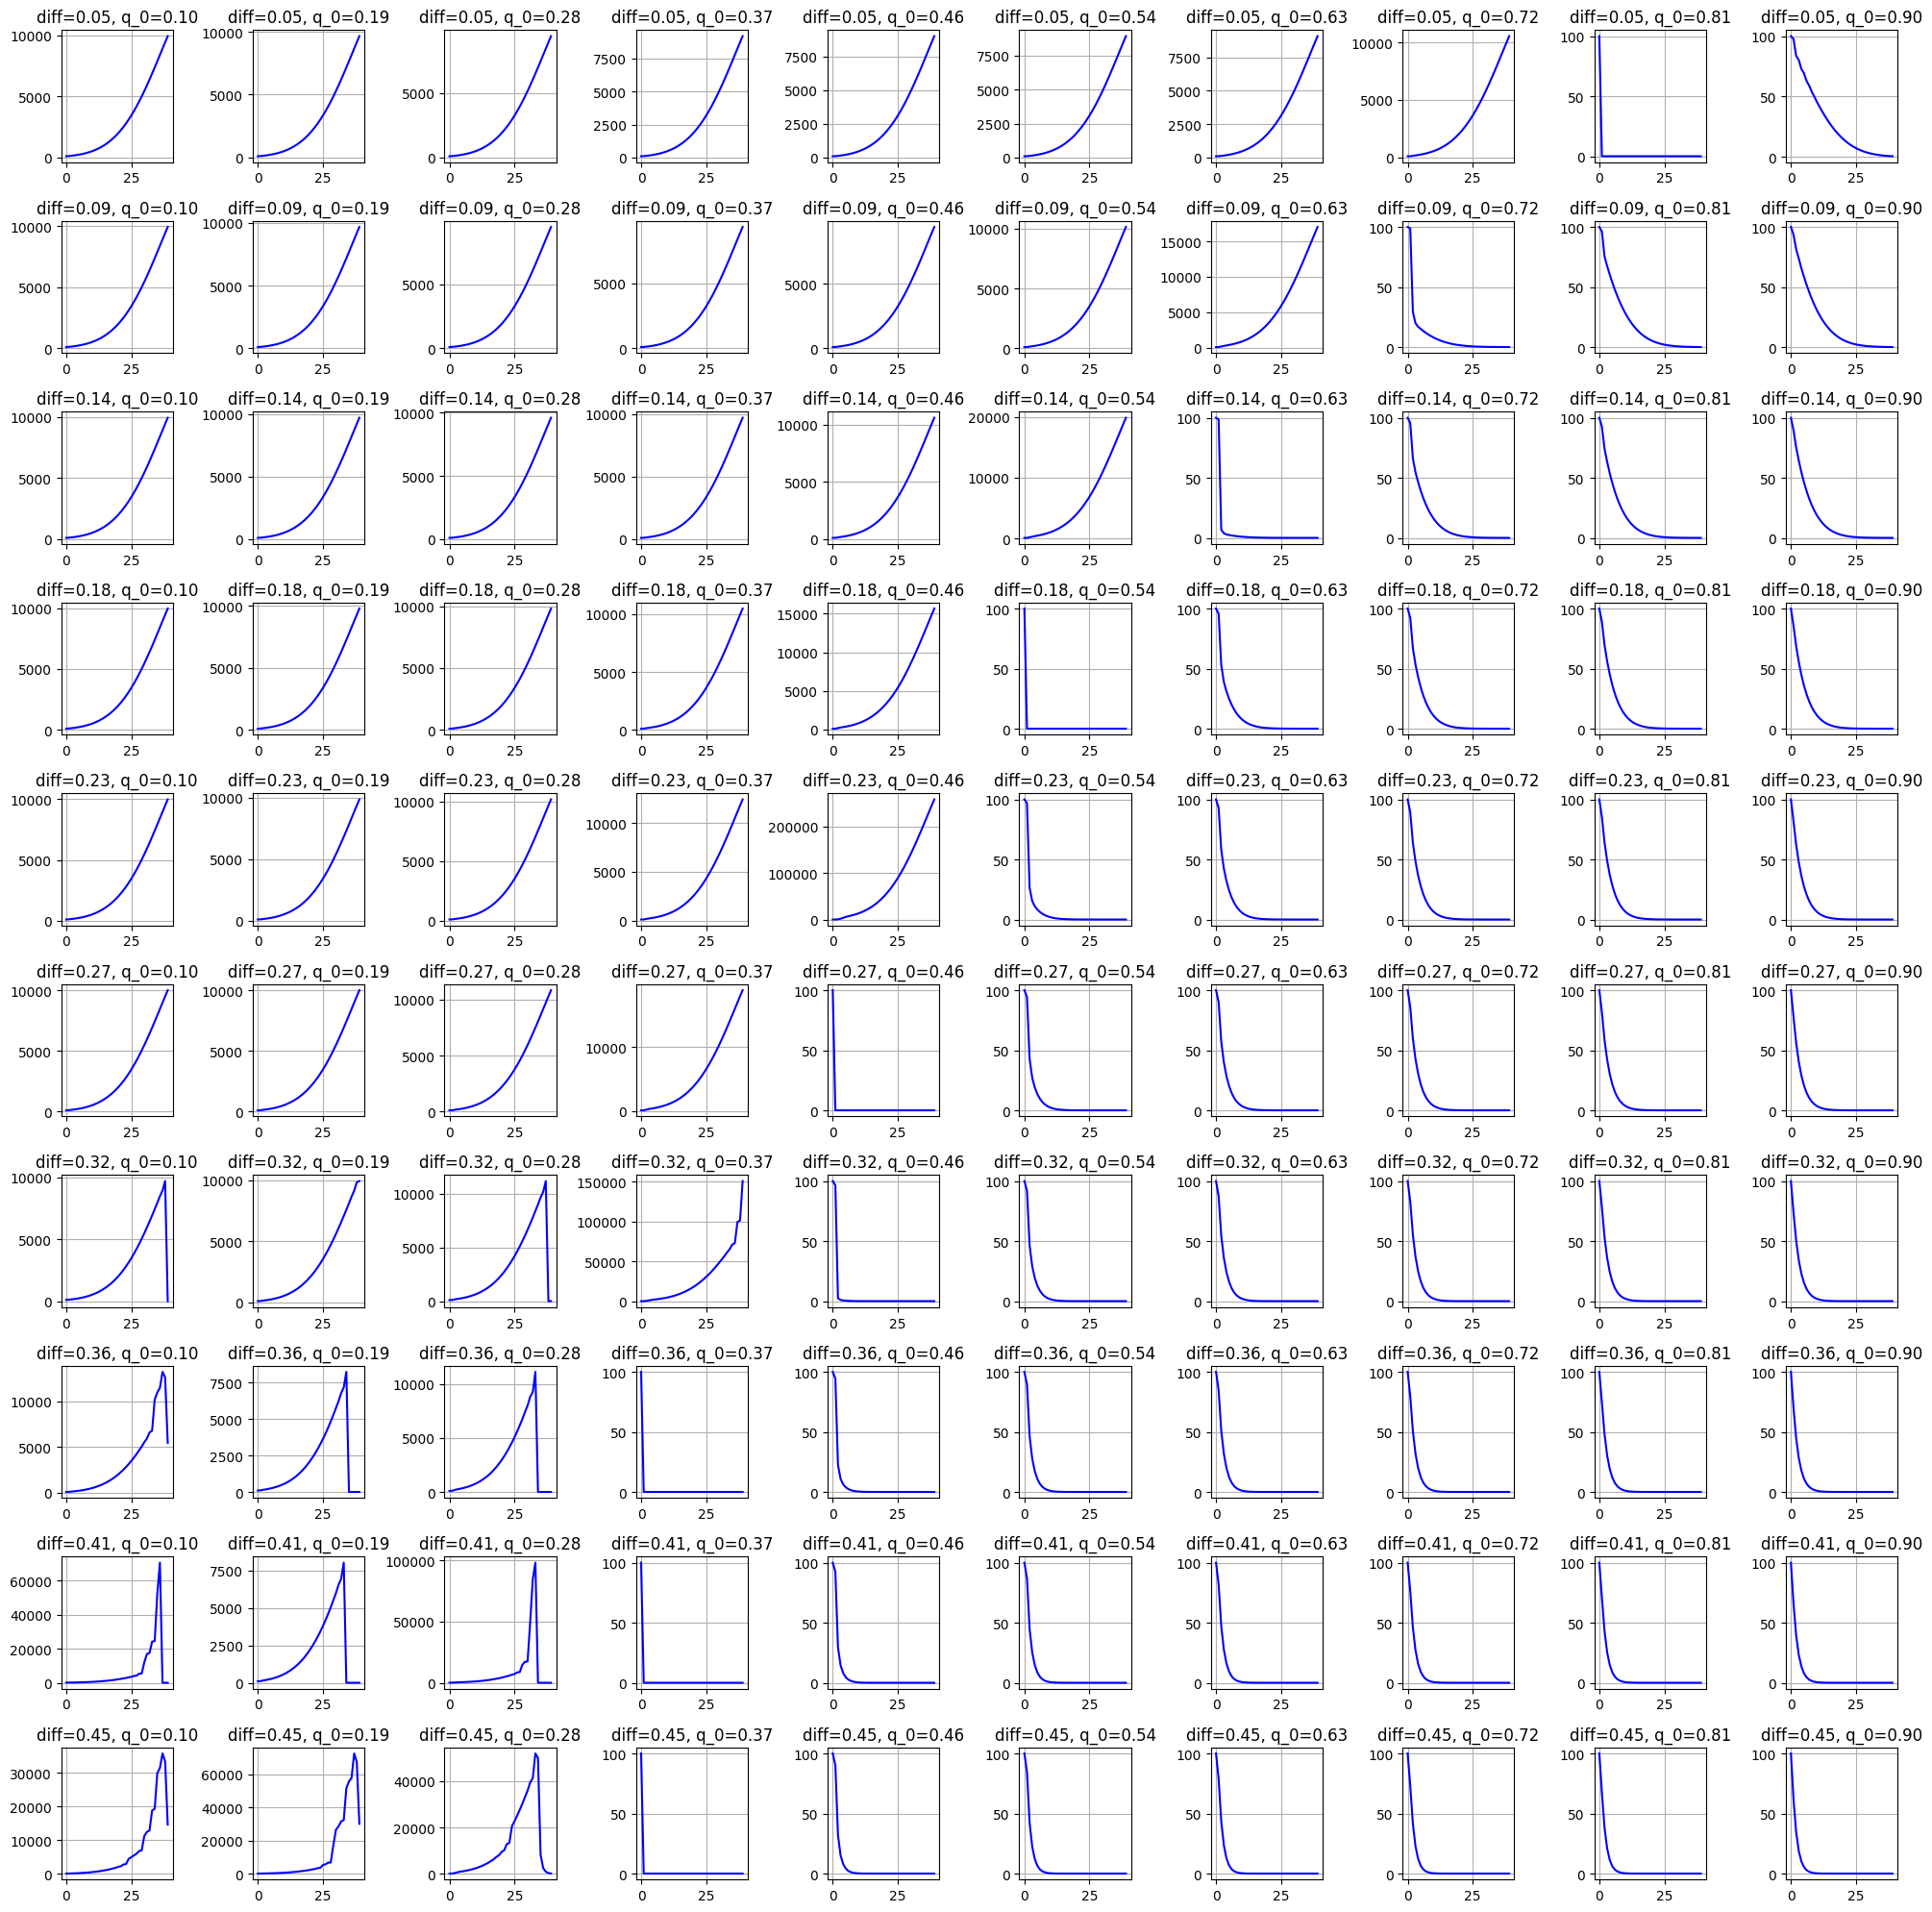

In [38]:
#same as prior multiplots but for various q_0, and difference between s and m_max_start
m_max_start = 0.2
m_max_end = 0.05
diffs = np.linspace(0.05, 0.45, 10)
q_0s = np.linspace(0.1, 0.9, 10)
pops_all = []

for diff in diffs:
    for q_0 in q_0s:
        s = m_max_start + diff
        pops = diploid_locus_model_gradual(m_max_start, m_max_end, s, n_0, q_0, generations=40)
        pops_all.append(pops)

#plot all the runs in a grid of 10x10 subplots
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i, pops in enumerate(pops_all):
    ax = axs[i // 10, i % 10]
    ax.plot(pops, color='blue')
    ax.set_title(f'diff={diffs[i // 10]:.2f}, q_0={q_0s[i % 10]:.2f}')
    ax.grid()
plt.tight_layout()
plt.show()